# Comparing ROQ with Neo and Bao on IMDB Synthetic Queries
## Roq Model Architecture
- query level data is processed by Graph Neural Networks using Pytorch-Geometric
- The plan level data is processed using TCNNs
- The aleatoric loss function is used


In [7]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import pandas as pd
import numpy as np
import random
import pickle
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from IPython.display import clear_output
import math
from sklearn.model_selection import train_test_split
from itertools import compress
from torch_geometric.data import Data
from torch_geometric.transforms import BaseTransform
from torch_geometric.loader import DataLoader
from util.eval_util import describe_plot, plot_step_curve
from util.util import set_seed
from pyg_data import queryPlanPGDataset


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
files_id = 'job_syn_all'
exp_id = 'job_syn'

seed = 0
train=False
try_gpu=True
reload_data = False
show_fig=True
num_workers = 10


In [127]:
plots_dir = './plots'
if not os.path.exists(plots_dir):
    os.mkdir(plots_dir)

In [5]:
if try_gpu:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')

In [6]:
set_seed(seed)

pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 200)

In [162]:
# TODO: figure out why query_ids are reused

# Load train, validation, and test datasets
print("loading train")
train_set = queryPlanPGDataset(
    split= 'train', files_id = files_id,
    labeled_data_dir='../labeled_data/',
    force_reload=False, seed = seed,
    # val_samples = 0.05, test_samples = 0.05
    )
print("Number of queries in training dataset: ",
      train_set.len())

print("loading val")
val_set = queryPlanPGDataset(
    split= 'val', files_id = files_id,
    )
print("Number of queries in vlidation dataset: ",
      val_set.len())

print("loading test")
test_set = queryPlanPGDataset(
    split= 'test', files_id = files_id,
    )
print("Number of queries in test dataset: ",
      test_set.len())

loading train
Number of queries in training dataset:  58268
loading val
Number of queries in vlidation dataset:  3068
loading test
Number of queries in test dataset:  3237


In [106]:
torch.unique(train_set.num_joins)

tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [107]:
np.unique(np.array(train_set.query_id)).shape

(4483,)

In [108]:
np.unique(np.array(val_set.query_id)).shape

(236,)

In [109]:
np.unique(np.array(test_set.query_id)).shape

(249,)

In [112]:
from util.data_transform import *

# Perform data transformations on inputs 
drop_const = dropConst(train_set)
train_set = drop_const(train_set)
val_set = drop_const(val_set)
test_set = drop_const(test_set)

null_imp = nullImputation(train_set)
train_set = null_imp(train_set)
val_set = null_imp(val_set)
test_set = null_imp(test_set)

minmax_scale = minmaxScale(train_set)
train_set = minmax_scale(train_set)
val_set = minmax_scale(val_set)
test_set = minmax_scale(test_set)

# Initialize data transformations on targets 
yTransFunc_log = target_log_transform(train_set)
# Transform targets for Roq
train_set = yTransFunc_log.transform(train_set)
val_set = yTransFunc_log.transform(val_set)
test_set = yTransFunc_log.transform(test_set)

In [19]:
plan_attr_shape = train_set[0].plan_attr.shape
plan_ord_shape = train_set[0].plan_ord.shape
graph_attr_shape= train_set[0].graph_attr.shape
edge_attr_shape = train_set[0].edge_attr_s.shape
node_attr_shape = train_set[0].x_s.shape

In [113]:
config ={'TCNNin': 64,
 'TCNNout': 32,
 'batch_size': 512,
 'dropout': 0.12333583157720673,
 'finalMLPin': 128,
 'finalMLPout': 128,
 'lr': 0.00035,
 'node_embd_dim': 16,
 'qp_attheads': 1,
 'qp_gnn_ls': 3,
 'query_module_out': 64}

batch_size=config['batch_size']

In [116]:
follow_batch = ['x_s']#,'edge_index_s','edge_index_t']

# train_loader = DataLoader(train_set, batch_size=batch_size,
#                          shuffle=False, num_workers=0, follow_batch=follow_batch,
#                         #  persistent_workers=True
#                          )
val_loader = DataLoader(val_set, batch_size=batch_size,
                         shuffle=False, num_workers=num_workers, 
                         follow_batch=follow_batch,
                        #  persistent_workers=True
                         )
test_loader = DataLoader(test_set, batch_size=batch_size,
                         shuffle=False, num_workers=num_workers, 
                         follow_batch=follow_batch,
                        #  persistent_workers=True
                         )

In [119]:
import pickle


with open('../results/qerror_dict_{}.pkl'.format(exp_id), 'rb') as file:
    qerror_dict = pickle.load(file)

with open('../results/corr_dict_{}.pkl'.format(exp_id), 'rb') as file:
    corr_dict = pickle.load(file)

# with open('.\\results\\qerror_dict_{}.pkl'.format(wlshift_exp_id), 'rb') as file:
#     qerror_wlshift_dict = pickle.load(file)

# with open('.\\results\\corr_dict_{}.pkl'.format(wlshift_exp_id), 'rb') as file:
#     corr_wlshift_dict = pickle.load(file)
    
with open('../results/rt_res_dict_{}.pkl'.format(exp_id), 'rb') as file:
    rt_res_dict = pickle.load(file)

with open('../results/so_res_dict_{}.pkl'.format(exp_id), 'rb') as file:
    so_res_dict = pickle.load(file)

with open('../results/agg_res_dict_{}.pkl'.format(exp_id), 'rb') as file:
    agg_res_dict = pickle.load(file)

In [120]:
runtimes_all = []
for i in rt_res_dict:
    runtimes_all.append(rt_res_dict[i].values)
runtimes_all=np.array(runtimes_all)
runtimes_all_df = rt_res_dict[0].copy()
runtimes_all_df.loc[:, :] = runtimes_all.mean(axis=0)
runtimes_all_df

,optimizer,optimizer pruned,Neo,Bao,base model,base model pruned,mc dropout,mc dropout pruned,conservative,cons. data unc.,cons. model unc.,cons. prun. RN,cons. prun. SO,cons. prun. data unc. RN,cons. prun. data unc. SO,cons. prun. model unc. RN,cons. prun. model unc. SO,risk,risk data unc.,risk model unc.,risk prun. RN,risk prun. SO,risk prun. data unc. RN,risk prun. data unc. SO,risk prun. model unc. RN,risk prun. model unc. SO,best
0,0.106686,0.106686,0.112646,0.117236,0.113153,0.121318,0.114493,0.115256,0.118971,0.118971,0.112971,0.118971,0.113439,0.118971,0.113439,0.109100,0.111878,0.111392,0.111392,0.114493,0.115256,0.109690,0.112155,0.112155,0.112373,0.111878,0.084396
1,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000567,0.000533,0.000539,0.000539,0.000580,0.000525,0.000525,0.000525,0.000525,0.000580,0.000591,0.000567,0.000567,0.000567,0.000533,0.000591,0.000533,0.000567,0.000543,0.000591,0.000427
2,2.605891,2.605891,2.603959,2.603315,2.603959,2.603959,2.639364,2.612585,2.627452,2.627452,2.613229,2.614202,2.628665,2.628665,2.628665,2.612016,2.612016,2.639364,2.639364,2.639603,2.612585,2.637696,2.640576,2.640576,2.640576,2.623928,2.594331
3,14.329805,14.336600,14.329805,7.627906,12.654331,12.654331,12.617339,12.614788,12.556376,12.556376,12.665164,14.214644,14.214644,12.556376,12.556376,12.665164,12.628202,12.580378,12.580378,12.615842,12.614788,12.568498,12.600132,12.566759,12.600132,12.604405,5.947163
4,0.071569,0.071569,0.068703,0.078487,0.069406,0.069406,0.070230,0.070056,0.068661,0.068661,0.070230,0.068661,0.068619,0.068661,0.068619,0.071801,0.067958,0.070230,0.070230,0.070230,0.070056,0.068702,0.068702,0.069974,0.068660,0.070230,0.065071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,0.000498,0.000498,0.048997,0.149212,0.000498,0.000498,0.000626,0.000598,0.000617,0.000611,0.000712,0.000584,0.000573,0.000578,0.000566,0.000712,0.000712,0.000638,0.000638,0.000661,0.000610,0.000633,0.000610,0.000610,0.000610,0.000661,0.000498
245,0.126424,0.126424,0.123926,0.124239,0.089909,0.117408,0.089438,0.106702,0.105037,0.105037,0.095949,0.113628,0.107064,0.113628,0.114693,0.098650,0.100493,0.089438,0.089438,0.098186,0.106702,0.099505,0.113579,0.106674,0.113579,0.100753,0.078146
246,0.720521,0.720521,0.720521,0.720521,0.805593,0.720521,0.656072,0.686048,0.641276,0.652769,0.659586,0.641276,0.665419,0.652769,0.676912,0.659586,0.671079,0.674555,0.674555,0.668722,0.704530,0.656072,0.674555,0.674555,0.652769,0.668722,0.599808
247,2.240059,2.240059,2.139706,2.338164,2.139706,2.199918,2.172681,2.216136,2.173562,2.173562,2.172681,2.156634,2.156634,2.173562,2.173562,2.250199,2.222189,2.172681,2.172681,2.172681,2.216136,2.216136,2.215254,2.216136,2.232182,2.250199,2.139706


In [121]:
subopts_all = []
for i in so_res_dict:
    subopts_all.append(so_res_dict[i].values)
subopts_all=np.array(subopts_all)
subopts_all_df = so_res_dict[0].copy()
subopts_all_df.loc[:, :] = subopts_all.mean(axis=0)
subopts_all_df

,optimizer,optimizer pruned,Neo,Bao,base model,base model pruned,mc dropout,mc dropout pruned,conservative,cons. data unc.,cons. model unc.,cons. prun. RN,cons. prun. SO,cons. prun. data unc. RN,cons. prun. data unc. SO,cons. prun. model unc. RN,cons. prun. model unc. SO,risk,risk data unc.,risk model unc.,risk prun. RN,risk prun. SO,risk prun. data unc. RN,risk prun. data unc. SO,risk prun. model unc. RN,risk prun. model unc. SO
0,1.264102,1.264102,1.334726,1.389107,1.340733,1.437480,1.356608,1.365653,1.409666,1.409666,1.338573,1.409666,1.344117,1.409666,1.344117,1.292706,1.325621,1.319863,1.319863,1.356608,1.365653,1.299705,1.328908,1.328908,1.331491,1.325621
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.327415,1.247348,1.261530,1.261530,1.358571,1.229257,1.229257,1.229257,1.229257,1.358571,1.383920,1.327415,1.327415,1.327415,1.247348,1.383920,1.247348,1.327415,1.272697,1.383920
2,1.004456,1.004456,1.003711,1.003463,1.003711,1.003711,1.017358,1.007036,1.012767,1.012767,1.007284,1.007659,1.013234,1.013234,1.013234,1.006817,1.006817,1.017358,1.017358,1.017451,1.007036,1.016715,1.017826,1.017826,1.017826,1.011408
3,2.409520,2.410662,2.409520,1.282613,2.127793,2.127793,2.121573,2.121144,2.111322,2.111322,2.129614,2.390156,2.390156,2.111322,2.111322,2.129614,2.123399,2.115358,2.115358,2.121321,2.121144,2.113360,2.118680,2.113068,2.118680,2.119398
4,1.099854,1.099854,1.055818,1.206176,1.066610,1.066610,1.079286,1.076611,1.055174,1.055174,1.079286,1.055174,1.054529,1.055174,1.054529,1.103418,1.044362,1.079286,1.079286,1.079286,1.076611,1.055799,1.055799,1.075341,1.055154,1.079286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,1.000000,1.000000,98.377214,299.588320,1.000000,1.000000,1.256965,1.199713,1.239253,1.225945,1.429871,1.173193,1.149832,1.159885,1.136525,1.429871,1.429871,1.281570,1.281570,1.327525,1.224318,1.270273,1.224318,1.224318,1.224318,1.327525
245,1.617787,1.617787,1.585813,1.589822,1.150523,1.502411,1.144498,1.365404,1.344110,1.344110,1.227812,1.454045,1.370042,1.454045,1.467667,1.262375,1.285951,1.144498,1.144498,1.256439,1.365404,1.273313,1.453415,1.365050,1.453415,1.289282
246,1.201253,1.201253,1.201253,1.201253,1.343084,1.201253,1.093804,1.143779,1.069136,1.088297,1.099662,1.069136,1.109387,1.088297,1.128548,1.099662,1.118823,1.124618,1.124618,1.114894,1.174593,1.093804,1.124618,1.124618,1.088297,1.114894
247,1.046900,1.046900,1.000000,1.092750,1.000000,1.028140,1.015411,1.035720,1.015823,1.015823,1.015411,1.007911,1.007911,1.015823,1.015823,1.051639,1.038549,1.015411,1.015411,1.015411,1.035720,1.035720,1.035307,1.035720,1.043219,1.051639


In [122]:
agg_res_all = []
for i in agg_res_dict:
    agg_res_all.append(agg_res_dict[i].values)
agg_res_all=np.array(agg_res_all)
agg_res_all_df = agg_res_dict[0].copy()
agg_res_all_var_df = agg_res_dict[0].copy()
agg_res_all_df.loc[:, :] = agg_res_all.mean(axis=0)
agg_res_all_var_df.loc[:, :] = agg_res_all.std(axis=0)

In [123]:
labels = [
        # 'optimizer pruned',
        'Neo','Bao',
        # 'Neo+','Bao+',
        'base model',#'base model pruned',
        # 'mc dropout','mc dropout pruned',
        'conservative','cons. prun. RN','cons. prun. SO',
        'risk','risk prun. RN','risk prun. SO',
        ]
columns =['improved_runtime','regressed_runtime','total_runtime_change%',
          'mean','50%','70%','90%','95%','99%'
          ]
sub = agg_res_all_df.loc[labels,columns]
sub[['improved_runtime','regressed_runtime']]=sub[['improved_runtime','regressed_runtime']]/runtimes_all_df.optimizer.sum()
sub

,improved_runtime,regressed_runtime,total_runtime_change%,mean,50%,70%,90%,95%,99%
Neo,0.170295,0.141781,-0.028513,24.334151,1.102472,1.400635,13.082198,28.739509,382.277674
Bao,0.225146,0.382985,0.157839,55.864684,1.161951,1.906769,22.620607,119.086261,1493.904281
base model,0.141233,0.368452,0.227219,294.453682,1.072538,1.237604,8.341765,25.825653,481.053611
conservative,0.167490,0.205347,0.037857,290.528847,1.087571,1.247470,5.646525,20.978395,320.473623
cons. prun. RN,0.151384,0.131156,-0.020228,11.578193,1.091182,1.255713,6.230734,24.130726,167.756878
cons. prun. SO,0.162132,0.170003,0.007871,281.277952,1.083971,1.238062,5.790400,23.045631,174.463438
risk,0.157918,0.318641,0.160723,290.725696,1.085794,1.259252,5.608021,17.777204,418.955239
risk prun. RN,0.134024,0.101000,-0.033024,9.438065,1.086303,1.267173,5.641651,23.058985,136.623900
risk prun. SO,0.156122,0.133623,-0.022500,9.418381,1.089313,1.267235,5.736657,21.474381,138.261910


In [124]:
agg_res_all_df.loc[labels,:].sort_values(by='total_runtime_change%')

,improved,improved_runtime,average_improvement,regressed,regressed_runtime,average_regression,unchanged,total_runtime_change%,total_runtime_change,average_runtime_change,total_subopt,mean,50%,60%,70%,80%,90%,95%,99%,max
risk prun. RN,0.379920,52.413588,0.551940,0.474699,39.498663,0.331706,0.145382,-0.033024,-12.914925,-0.051867,0.966976,9.438065,1.086303,1.155685,1.267173,1.667530,5.641651,23.058985,136.623900,959.077810
Neo,0.199197,66.598060,1.345697,0.368675,55.447242,0.593622,0.432129,-0.028513,-11.150818,-0.044782,0.971487,24.334151,1.102472,1.190044,1.400635,2.489140,13.082198,28.739509,382.277674,2672.270061
risk prun. SO,0.390361,61.055665,0.630477,0.462651,52.256627,0.453883,0.146988,-0.022500,-8.799038,-0.035338,0.977500,9.418381,1.089313,1.147135,1.267235,1.637332,5.736657,21.474381,138.261910,959.077810
cons. prun. RN,0.392771,59.202560,0.606301,0.479518,51.291997,0.426510,0.127711,-0.020228,-7.910564,-0.031769,0.979772,11.578193,1.091182,1.154103,1.255713,1.669918,6.230734,24.130726,167.756878,1209.888966
cons. prun. SO,0.399197,63.405927,0.641501,0.461847,66.484151,0.579689,0.138956,0.007871,3.078224,0.012362,1.007871,281.277952,1.083971,1.140912,1.238062,1.624218,5.790400,23.045631,174.463438,68137.420037
conservative,0.393574,65.501259,0.670681,0.473092,80.306113,0.676448,0.133333,0.037857,14.804854,0.059457,1.037857,290.528847,1.087571,1.144886,1.247470,1.661325,5.646525,20.978395,320.473623,70051.723815
Bao,0.195984,88.049119,1.814970,0.454618,149.775974,1.274996,0.349398,0.157839,61.726855,0.247899,1.157839,55.864684,1.161951,1.331855,1.906769,5.685471,22.620607,119.086261,1493.904281,4168.106149
risk,0.384739,61.757763,0.649190,0.469880,124.612540,1.051465,0.145382,0.160723,62.854776,0.252429,1.160723,290.725696,1.085794,1.143038,1.259252,1.608205,5.608021,17.777204,418.955239,70107.215438
base model,0.200000,55.232772,1.116449,0.296386,144.092677,1.940870,0.503614,0.227219,88.859905,0.356867,1.227219,294.453682,1.072538,1.125033,1.237604,1.645138,8.341765,25.825653,481.053611,70324.843680


In [125]:
sub = agg_res_all_df.loc[labels,:]
sub_var = agg_res_all_var_df.loc[labels,:]

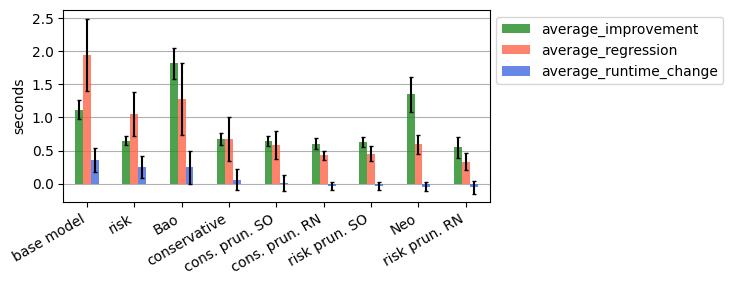

In [128]:
import matplotlib.pyplot as plt
features = ["average_improvement","average_regression","average_runtime_change"]
sub = sub.sort_values(by='total_runtime_change%',ascending=False)
ax = sub.loc[:,features].plot.bar(logy=False,figsize=[5.5,2.5],
            color=['forestgreen','tomato','royalblue'], yerr=sub_var.loc[:,features],
               align='center', alpha=0.8, ecolor='black', capsize=1.5)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=30,ha='right')
plt.ylabel('seconds')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
# plt.show()
plt.savefig('./plots/roq_neo_bao_avg_runtime_bar_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)

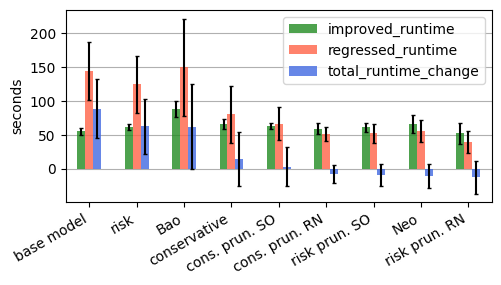

In [129]:
import matplotlib.pyplot as plt

features = ["improved_runtime","regressed_runtime","total_runtime_change"]
sub = sub.sort_values(by='total_runtime_change%',ascending=False)
ax = sub.loc[:,features].plot.bar(logy=False,figsize=[5.5,2.5],
            color=['forestgreen','tomato','royalblue'], yerr=sub_var.loc[:,features],
               align='center', alpha=0.8, ecolor='black', capsize=1.5)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=30,ha='right')
plt.ylabel('seconds')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
# plt.show()
# plt.savefig('./plots/roq_neo_bao_tot_runtime_bar_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)

In [130]:
runtimes_all_df.optimizer.sum()

391.0753743648529

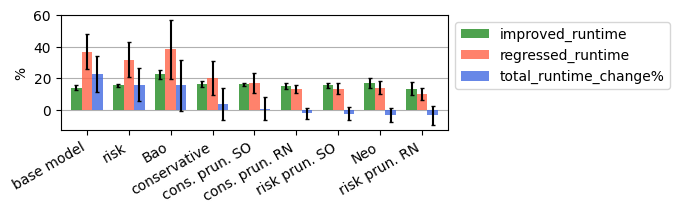

In [131]:
import matplotlib.pyplot as plt

sub = sub.sort_values(by='total_runtime_change%',ascending=False)
sub_perc = sub.copy()
sub_var_perc=sub_var.copy()
sub_perc[["improved_runtime","regressed_runtime"]] = sub_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_var_perc[["improved_runtime","regressed_runtime"]] = sub_var_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_perc=sub_perc*100
sub_var_perc=sub_var_perc*100
ax = sub_perc.loc[sub_perc.index,["improved_runtime","regressed_runtime","total_runtime_change%"]].plot.bar(logy=False,
                            figsize=[5,1.5], yerr=sub_var_perc, capsize=1.5,
                            color=['forestgreen','tomato','royalblue'],alpha=0.8,width=0.75)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=30,ha='right')
plt.ylabel('%')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
# plt.show()
plt.savefig('./plots/roq_neo_bao_tot_runtime_bar_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)

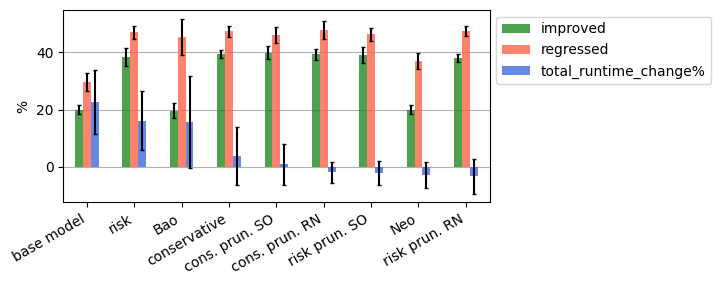

In [132]:
import matplotlib.pyplot as plt

# sub = sub.sort_values(by='total_runtime_change%',ascending=False)
# sub_perc=sub*100
# ax = sub_perc.loc[sub.index,["improved","regressed","total_runtime_change%"]].plot.bar(logy=False,figsize=[5.5,2.5],
#                               color=['forestgreen','tomato','royalblue'])

features = ["improved","regressed","total_runtime_change%"]
sub = sub.sort_values(by='total_runtime_change%',ascending=False)
sub_perc=sub*100
sub_var_perc=sub_var*100
ax = sub_perc.loc[:,features].plot.bar(logy=False,figsize=[5.5,2.5],
            color=['forestgreen','tomato','royalblue'], yerr=sub_var_perc.loc[:,features],
               align='center', alpha=0.8, ecolor='black', capsize=1.5)

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=30,ha='right')
plt.ylabel('%')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
# plt.show()
plt.savefig('./plots/roq_neo_bao_perc_runtime_bar_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)

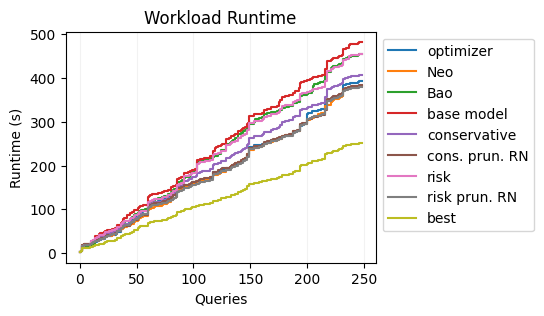

In [133]:
labels = [
                 'optimizer',#'optimizer pruned',
                 'Neo','Bao',
                #  'Neo+','Bao+',
                 'base model',#'base model pruned',
                #  'mc dropout',
                 'conservative','cons. prun. RN',
                 'risk','risk prun. RN',
                'best'
                ]

values = runtimes_all_df.loc[:,labels].values.T

plot_step_curve(values,labels,scale='linear',figsize=[4,3],
                save_to='./plots/runtime_step_ext_{}.png'.format(exp_id),bbox_to_anchor=(1.0, 1.0),show_fig=show_fig)

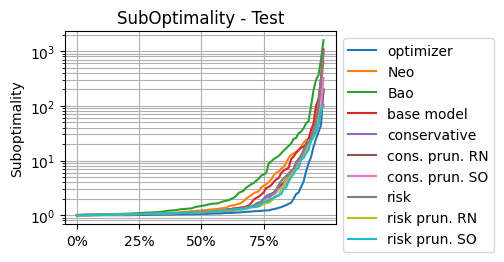

In [134]:
labels = [
        'optimizer',
        # 'optimizer pruned',
        'Neo','Bao',
        'base model',#'base model pruned',
        # 'mc dropout','mc dropout pruned',
        'conservative','cons. prun. RN','cons. prun. SO',
        'risk','risk prun. RN','risk prun. SO',
        ]
values = subopts_all_df.loc[:,labels].values.T

describe_plot(values,labels, 
              metric_label='Suboptimality',
              plot_title='SubOptimality - Test', 
              log_scale = True, figsize=[3.5,2.5],plot_x_every=25,
             bbox_to_anchor=(1.0, 1.0),
             show_fig=show_fig)

In [135]:
sub = agg_res_all_df.loc[labels,:]
sub_var = agg_res_all_var_df.loc[labels,:]

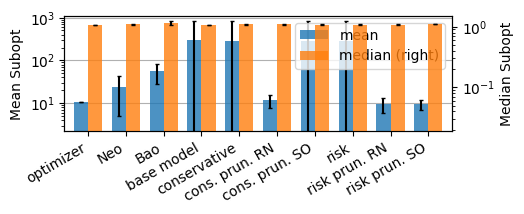

In [136]:
sub.rename({'50%':'median'},axis=1,inplace=True)
sub_var.rename({'50%':'median'},axis=1,inplace=True)
ax=sub.loc[labels,['mean','median']].plot.bar(logy=True,secondary_y=['median'],figsize=[5,1.5],
                yerr=sub_var.loc[labels,['mean','median']],
               align='center', alpha=0.8, ecolor='black', capsize=1.5, width=0.75)
ax.set_xticks(ticks=np.arange(len(labels)),labels=labels,rotation=30,ha='right')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
# ax.set_xlabel('Plan Selection Strategy')
ax.set_ylabel('Mean Subopt')
ax.right_ax.set_ylabel('Median Subopt')
plt.savefig('./plots/subopt_bar_main_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)
plt.show()

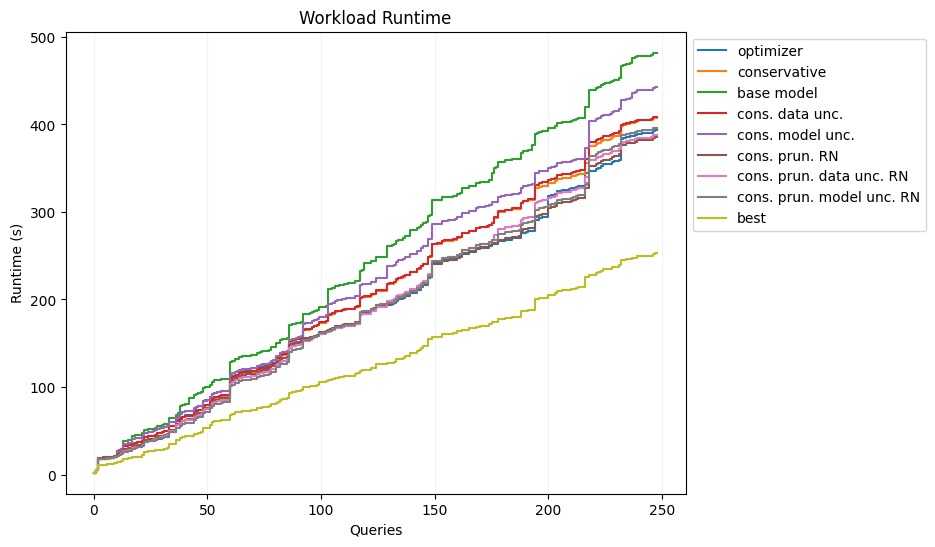

In [137]:
labels = [
                 'optimizer',
                 'conservative',
                 'base model',
                 'cons. data unc.', 
                 'cons. model unc.',
                 'cons. prun. RN', 
                 'cons. prun. data unc. RN', 
                 'cons. prun. model unc. RN',
                 'best'
                ]
values = runtimes_all_df.loc[:,labels].values.T

plot_step_curve(values,labels,scale='linear',figsize=[8,6],
                bbox_to_anchor=(1.0, 1.0),show_fig=show_fig)


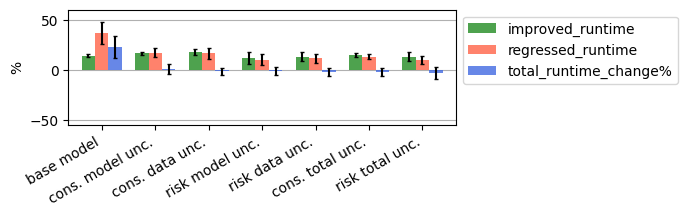

In [138]:
labels = [
                 'base model',
                 'cons. prun. RN',
                 'cons. prun. data unc. RN',
                 'cons. prun. model unc. RN',
                 'risk prun. RN', 
                 'risk prun. data unc. RN', 
                 'risk prun. model unc. RN', 
                ]

chart_labels = ['base model',
           'cons. total unc.','cons. data unc.','cons. model unc.',
           'risk total unc.','risk data unc.','risk model unc.'
           ]

features = ["improved_runtime","regressed_runtime","total_runtime_change%"]

sub = agg_res_all_df.loc[labels,features]
sub_var = agg_res_all_var_df.loc[labels,features]

sub.index=chart_labels
sub_var.index=chart_labels

sub = sub.sort_values(by='total_runtime_change%',ascending=False)
sub_perc = sub.copy()
sub_var_perc = sub_var.copy()
sub_perc[["improved_runtime","regressed_runtime"]] = sub_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_var_perc[["improved_runtime","regressed_runtime"]] = sub_var_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_perc=sub_perc*100
sub_var_perc=sub_var_perc*100

sub = sub.sort_values(by='total_runtime_change%',ascending=False)
ax = sub_perc.plot.bar(logy=False,figsize=[5,1.5],
            color=['forestgreen','tomato','royalblue'], yerr=sub_var_perc,
               align='center', alpha=0.8, ecolor='black', capsize=1.5, width=.75)
plt.legend(bbox_to_anchor=(1, 1))
plt.xticks(rotation=30,ha='right')
plt.ylabel('%')
ax.grid(visible=True,which='both',axis='y')
ax.set_ylim((-55,60))
ax.set_axisbelow(True)
# plt.show()
plt.savefig('./plots/runtime_bar_mode_data_unc_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)

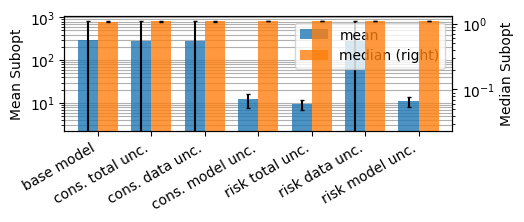

In [139]:
labels = [
                 'base model',
                 'cons. prun. SO',
                 'cons. prun. data unc. SO',
                 'cons. prun. model unc. SO',
                 'risk prun. SO', 
                 'risk prun. data unc. SO', 
                 'risk prun. model unc. SO', 
                ]

chart_labels = [
    'base model',
           'cons. total unc.','cons. data unc.','cons. model unc.',
           'risk total unc.','risk data unc.','risk model unc.'
           ]

features=['mean','50%']

sub = agg_res_all_df.loc[labels,features]
sub_var = agg_res_all_var_df.loc[labels,features]

sub.index=chart_labels
sub_var.index=chart_labels

sub.rename({'50%':'median'},axis=1,inplace=True)
sub_var.rename({'50%':'median'},axis=1,inplace=True)
ax=sub.plot.bar(logy=True,secondary_y=['median'],figsize=[5,1.5],
                yerr=sub_var,
               align='center', alpha=0.8, ecolor='black', capsize=1.5, width=.75)
ax.set_xticks(ticks=np.arange(len(chart_labels)),labels=chart_labels,rotation=30,ha='right')
ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)
# ax.set_xlabel('Plan Selection Strategy')
ax.set_ylabel('Mean Subopt')
ax.right_ax.set_ylabel('Median Subopt')
plt.savefig('./plots/subopt_bar_mode_data_unc_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)
plt.show()

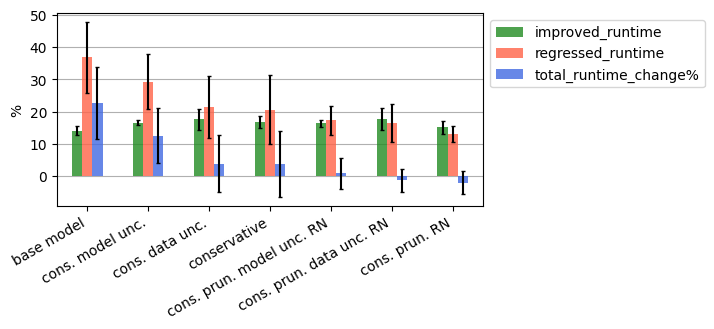

In [140]:
labels = [
                 'base model',
                 'conservative',
                 'cons. data unc.', 
                 'cons. model unc.',
                 'cons. prun. RN',
                 'cons. prun. data unc. RN',
                 'cons. prun. model unc. RN',
                ]
features = ["improved_runtime","regressed_runtime","total_runtime_change%"]

sub = agg_res_all_df.loc[labels,features]
sub_var = agg_res_all_var_df.loc[labels,features]

sub = sub.sort_values(by='total_runtime_change%',ascending=False)
sub_perc = sub.copy()
sub_var_perc = sub_var.copy()
sub_perc[["improved_runtime","regressed_runtime"]] = sub_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_var_perc[["improved_runtime","regressed_runtime"]] = sub_var_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_perc=sub_perc*100
sub_var_perc=sub_var_perc*100

sub = sub.sort_values(by='total_runtime_change%',ascending=False)
ax = sub_perc.plot.bar(logy=False,figsize=[5.5,2.5],
            color=['forestgreen','tomato','royalblue'], yerr=sub_var_perc,
               align='center', alpha=0.8, ecolor='black', capsize=1.5)
plt.legend(bbox_to_anchor=(1, 1))
plt.xticks(rotation=30,ha='right')
plt.ylabel('%')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
# plt.show()
plt.savefig('./plots/runtime_bar_cons_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)

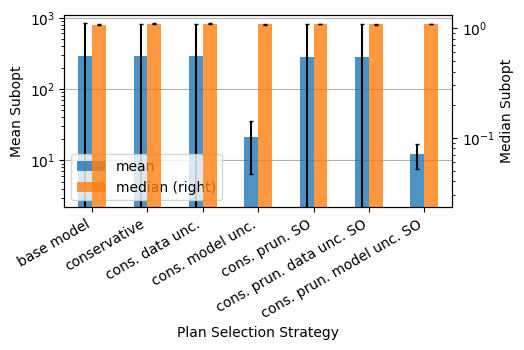

In [141]:
labels = [
                 'base model',
                 'conservative',
                 'cons. data unc.', 
                 'cons. model unc.',
                 'cons. prun. SO',
                 'cons. prun. data unc. SO',
                 'cons. prun. model unc. SO',
                ]

sub = agg_res_all_df.loc[labels,:]
sub_var = agg_res_all_var_df.loc[labels,:]

sub.rename({'50%':'median'},axis=1,inplace=True)
sub_var.rename({'50%':'median'},axis=1,inplace=True)
ax=sub.loc[labels,['mean','median']].plot.bar(logy=True,secondary_y=['median'],figsize=[5,2.5],
                yerr=sub_var.loc[labels,['mean','median']],
               align='center', alpha=0.8, ecolor='black', capsize=1.5)
ax.set_xticks(ticks=np.arange(len(labels)),labels=labels,rotation=30,ha='right')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
ax.set_xlabel('Plan Selection Strategy')
ax.set_ylabel('Mean Subopt')
ax.right_ax.set_ylabel('Median Subopt')
plt.savefig('./plots/subopt_bar_cons_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)
plt.show()

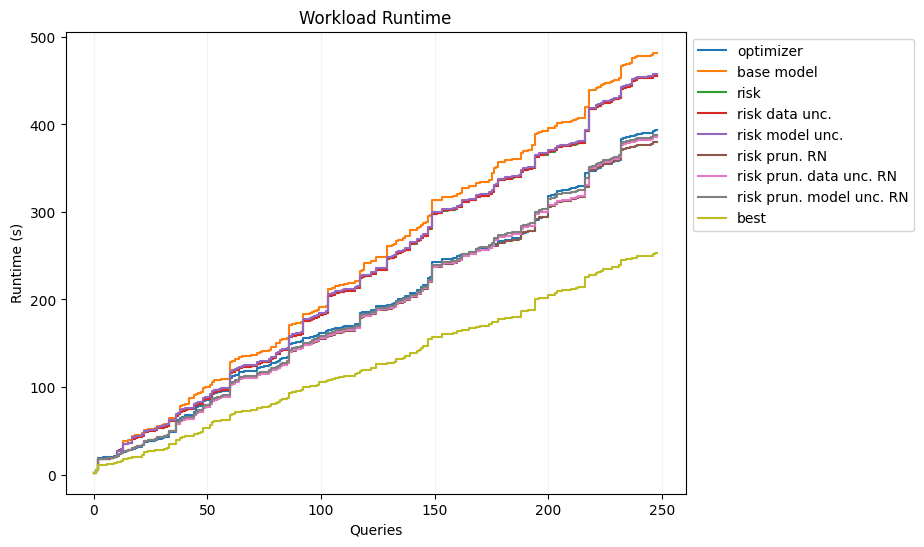

In [142]:
labels = [
                 'optimizer',
                 'base model',
                 'risk',
                 'risk data unc.', 
                 'risk model unc.',
                 'risk prun. RN', 
                 'risk prun. data unc. RN', 
                 'risk prun. model unc. RN', 
                 'best'
                ]

values = runtimes_all_df.loc[:,labels].values.T

plot_step_curve(values,labels,scale='linear',figsize=[8,6],
                bbox_to_anchor=(1.0, 1.0),show_fig=show_fig)

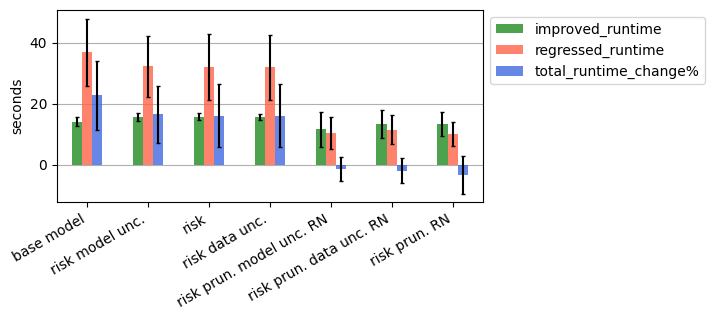

In [143]:
labels = [
                 'base model',
                 'risk',
                 'risk data unc.', 
                 'risk model unc.',
                 'risk prun. RN', 
                 'risk prun. data unc. RN', 
                 'risk prun. model unc. RN', 
                ]
features = ["improved_runtime","regressed_runtime","total_runtime_change%"]

sub = agg_res_all_df.loc[labels,features]
sub_var = agg_res_all_var_df.loc[labels,features]

sub = sub.sort_values(by='total_runtime_change%',ascending=False)
sub_perc = sub.copy()
sub_var_perc = sub_var.copy()
sub_perc[["improved_runtime","regressed_runtime"]] = sub_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_var_perc[["improved_runtime","regressed_runtime"]] = sub_var_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_perc=sub_perc*100
sub_var_perc=sub_var_perc*100

sub = sub.sort_values(by='total_runtime_change%',ascending=False)
ax = sub_perc.plot.bar(logy=False,figsize=[5.5,2.5],
            color=['forestgreen','tomato','royalblue'], yerr=sub_var_perc,
               align='center', alpha=0.8, ecolor='black', capsize=1.5)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=30,ha='right')
plt.ylabel('seconds')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
# plt.show()
plt.savefig('./plots/runtime_bar_risk_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)

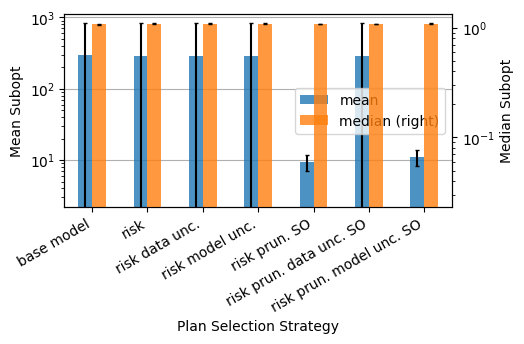

In [144]:
labels = [
                'base model',
                 'risk',
                 'risk data unc.', 
                 'risk model unc.',
                 'risk prun. SO', 
                 'risk prun. data unc. SO', 
                 'risk prun. model unc. SO', 
                ]

sub = agg_res_all_df.loc[labels,:]
sub_var = agg_res_all_var_df.loc[labels,:]

sub.rename({'50%':'median'},axis=1,inplace=True)
sub_var.rename({'50%':'median'},axis=1,inplace=True)

ax=sub.loc[labels,['mean','median']].plot.bar(logy=True,secondary_y=['median'],figsize=[5,2.5],
                yerr=sub_var.loc[labels,['mean','median']],
               align='center', alpha=0.8, ecolor='black', capsize=1.5)
ax.set_xticks(ticks=np.arange(len(labels)),labels=labels,rotation=30,ha='right')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
ax.set_xlabel('Plan Selection Strategy')
ax.set_ylabel('Mean Subopt')
ax.right_ax.set_ylabel('Median Subopt')
plt.savefig('./plots/subopt_bar_risk_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)
plt.show()

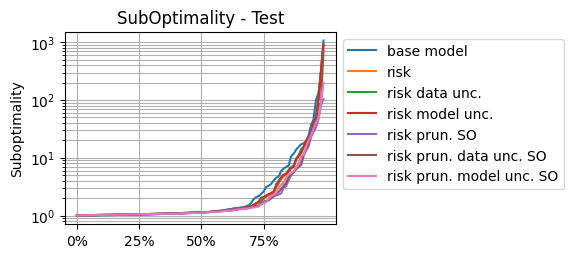

In [145]:
values = subopts_all_df.loc[:,labels].values.T

describe_plot(values,labels, 
              metric_label='Suboptimality',
              plot_title='SubOptimality - Test', 
              log_scale = True, figsize=[3.5,2.5],plot_x_every=25,
             save_to = './plots/sub_opt_line.png',
             bbox_to_anchor=(1.0, 1.0),
             show_fig=show_fig)

In [146]:
qerror_all = []
for i in qerror_dict:
    qerror_all.append(qerror_dict[i].values)
qerror_all=np.array(qerror_all)
qerror_all_df = qerror_dict[0].copy()
qerror_all_var_df = qerror_dict[0].copy()
qerror_all_df.loc[:, :] = qerror_all.mean(axis=0)
qerror_all_var_df.loc[:, :] = qerror_all.std(axis=0)

In [164]:
labels=['Bao','Neo','Roq']

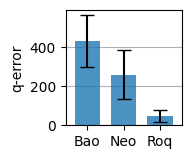

In [165]:
y = qerror_all_df[labels].mean(axis=0)
yerr = qerror_all_var_df[labels].mean(axis=0)
ax =y.plot.bar(logy=False,figsize=[1.5,1.5],yerr=yerr.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7)
ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)
ax.set_ylabel('q-error')
plt.xticks(rotation=0,ha='center')
# plt.legend(bbox_to_anchor=(1.0,1.0))
plt.savefig('./plots/qerror_bar_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)
plt.show()

In [149]:
res = qerror_all_df.describe(percentiles=[.5,.6,.7,.8,.90,.95,.99]).T
res.loc[:,['mean','std','50%','60%','70%','80%','90%','99%','max']]

,mean,std,50%,60%,70%,80%,90%,99%,max
Bao,430.013428,2428.501709,3.554732,6.065806,13.958136,38.882867,271.736450,8749.001250,72537.203125
Neo,258.084381,1394.826782,2.905831,4.295395,10.265928,33.039561,173.501761,5816.289648,41679.164062
Roq,47.240757,492.606110,3.147791,4.212094,6.431634,12.234892,37.770199,737.083738,20496.865234
Roq MCDO,46.089851,463.005646,3.125419,4.243314,6.473178,12.513564,38.096851,706.377695,18685.207031


In [150]:
res = qerror_all_var_df.describe(percentiles=[.5,.6,.7,.8,.90,.95,.99]).T
res.loc[:,['mean','50%','60%','70%','80%','90%','99%','max']]


,mean,50%,60%,70%,80%,90%,99%,max
Bao,131.804138,1.120157,1.849591,4.320603,13.301537,71.545721,3360.054971,21599.484375
Neo,125.059708,1.244831,1.980284,4.606788,14.030061,76.876447,2656.225488,22993.482422
Roq,32.798969,1.107861,1.737751,3.086825,6.581871,19.824657,567.722285,7881.055176
Roq MCDO,31.333183,1.143538,1.789737,3.160528,6.675441,19.226464,508.023245,7306.555176


In [151]:
corr_all = []
for i in corr_dict:
    corr_all.append(corr_dict[i].values)
corr_all=np.array(corr_all)
corr_all_df = corr_dict[0].copy()
corr_all_var_df = corr_dict[0].copy()
corr_all_df.loc[:, :] = corr_all.mean(axis=0)
corr_all_var_df.loc[:, :] = corr_all.std(axis=0)

In [152]:
corr_all_df

,Cost,Bao,Neo,Roq,Roq MCDO
Pearson,0.228858,0.702519,0.744010,0.642525,0.633792
Spearman,0.605916,0.599294,0.625625,0.697582,0.695797


In [153]:
corr_all_var_df

,Cost,Bao,Neo,Roq,Roq MCDO
Pearson,0.0,0.015341,0.020742,0.022187,0.021200
Spearman,0.0,0.018935,0.022700,0.013001,0.013126


In [154]:
labels = ['Cost','Bao','Neo','Roq']

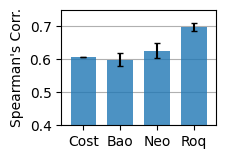

In [160]:

ax =corr_all_df.T[['Spearman']].loc[labels].plot.bar(logy=False,figsize=[2,1.5],yerr=corr_all_var_df.T[['Spearman']].loc[labels].T.values,
               align='center', alpha=0.8, ecolor='black', capsize=2.5,
               width=0.7)

ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)
ax.set_ylabel('Spearman\'s Corr.')
plt.ylim((0.4,0.75))
plt.xticks(rotation=0,ha='center')
legend = ax.legend()
legend.remove()

plt.savefig('./plots/spearman_corr_bar_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)
plt.show()

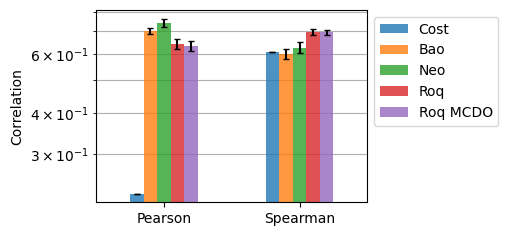

In [161]:
ax =corr_all_df.plot.bar(logy=True,figsize=[3.5,2.5],yerr=corr_all_var_df.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=2.5)
ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)
ax.set_ylabel('Correlation')
plt.xticks(rotation=0,ha='center')
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.show()